### 1) В среде Google Colab создали новый блокнот (notebook). Импортировали необходимые для работы библиотеки и модули. Настроили блокнот для работы с аппаратным ускорителем GPU.

In [2]:
# импорт модулей
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np


### 2) Загрузили набор данных IMDb, содержащий оцифрованные отзывы на фильмы, размеченные на два класса: позитивные и негативные. При загрузке набора данных параметр seed выбрали равным значению (4k – 1)=31, где k=8 – номер бригады. Вывели размеры полученных обучающих и тестовых массивов данных.

In [3]:
# загрузка датасета
from keras.datasets import imdb

vocabulary_size = 5000
index_from = 3

(X_train, y_train), (X_test, y_test) = imdb.load_data(
    path="imdb.npz",
    num_words=vocabulary_size,
    skip_top=0,
    maxlen=None,
    seed=31,
    start_char=1,
    oov_char=2,
    index_from=index_from
    )

# вывод размерностей
print('Shape of X train:', X_train.shape)
print('Shape of y train:', y_train.shape)
print('Shape of X test:', X_test.shape)
print('Shape of y test:', y_test.shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Shape of X train: (25000,)
Shape of y train: (25000,)
Shape of X test: (25000,)
Shape of y test: (25000,)


### 3) Вывели один отзыв из обучающего множества в виде списка индексов слов. Преобразовали список индексов в текст и вывели отзыв в виде текста. Вывели длину отзыва. Вывели метку класса данного отзыва и название класса (1 – Positive, 0 – Negative).

In [4]:
# создание словаря для перевода индексов в слова
# заргузка словаря "слово:индекс"
word_to_id = imdb.get_word_index()
# уточнение словаря
word_to_id = {key:(value + index_from) for key,value in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3
# создание обратного словаря "индекс:слово"
id_to_word = {value:key for key,value in word_to_id.items()}

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 3s 2us/step


In [5]:
print(X_train[26])
print('len:',len(X_train[26]))

[1, 13, 805, 8, 40, 14, 1179, 40, 13, 353, 8, 358, 32, 1179, 108, 13, 384, 3091, 2, 1849, 19, 6, 117, 1006, 5, 49, 836, 89, 70, 25, 140, 355, 21, 2, 13, 104, 9, 35, 463, 7, 15, 2063, 170, 355, 4, 293, 1834, 9, 4, 527, 116, 7, 4, 293, 289, 539, 15, 2, 56, 11, 4, 313, 12, 16, 17, 48, 36, 71, 467, 2, 5, 12, 2230, 72, 39, 126, 397, 928, 11, 68, 4598, 4, 22, 2, 18, 836, 5, 2, 21, 4, 34, 4, 1396, 458, 2, 12, 7, 148, 5, 889, 4, 20, 184, 753, 45, 6, 902, 88, 48, 4, 20, 16, 128, 2142, 12, 62, 28, 28, 77, 2, 4, 65, 5, 105, 26, 184, 948, 5, 50, 26, 49, 465, 5, 2, 1984, 388, 7, 4347, 200, 4, 452, 4, 539, 5, 4, 577, 11, 4, 154, 313, 225, 49, 52, 1006, 5, 2552, 2, 2, 43, 24, 195, 8, 202, 4, 22, 4, 1968, 12, 887, 4, 1962, 9, 184, 2509, 5, 2, 5, 127, 202, 4, 22, 6, 194, 2, 21, 1038, 94, 99, 117, 99, 522, 38, 11, 61, 652, 31, 8, 798, 894, 25, 66, 119, 3720, 1179, 108, 225, 6, 1257, 1166, 7, 986, 21, 4, 22, 1545, 99, 117, 8, 30, 2640]
len: 220


In [6]:
review_as_text = ' '.join(id_to_word[id] for id in X_train[26])
print(review_as_text)
print('len:',len(review_as_text))
print('Label:', y_train[26], '(', 'Positive' if y_train[26] == 1 else 'Negative', ')')

<START> i tried to like this slasher like i try to enjoy all slasher films i mean mindless <UNK> mixed with a little nudity and some suspense how can you go wrong but <UNK> i think is an example of that formula going wrong the main issue is the horrible acting of the main three girls that <UNK> up in the house it was as if they were under <UNK> and it stopped me from ever getting interested in their plight the film <UNK> for suspense and <UNK> but the by the numbers direction <UNK> it of those and leaves the movie pretty dull it's a shame because if the movie was better executed it would have have been <UNK> the story and characters are pretty creepy and there are some dark and <UNK> humorous moments of interaction between the mother the girls and the daughter in the old house there's some good nudity and occasional <UNK> <UNK> just not enough to give the film the kick it needed the finale is pretty twisted and <UNK> and does give the film a big <UNK> but sadly its too little too late 

### 4) Вывели максимальную и минимальную длину отзыва в обучающем множестве.

In [7]:
print('MAX Len: ',len(max(X_train, key=len)))
print('MIN Len: ',len(min(X_train, key=len)))

MAX Len:  2494
MIN Len:  11


### 5) Провели предобработку данных. Выбрали единую длину, к которой будут приведены все отзывы. Короткие отзывы дополнили спецсимволами, а длинные обрезали до выбранной длины.

In [8]:
# предобработка данных
from tensorflow.keras.utils import pad_sequences
max_words = 500
X_train = pad_sequences(X_train, maxlen=max_words, value=0, padding='pre', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_words, value=0, padding='pre', truncating='post')

### 6) Повторили пункт 4.

In [9]:
print('MAX Len: ',len(max(X_train, key=len)))
print('MIN Len: ',len(min(X_train, key=len)))

MAX Len:  500
MIN Len:  500


### 7) Повторили пункт 3. Сделали вывод о том, как отзыв преобразовался после предобработки.

In [10]:
print(X_train[26])
print('len:',len(X_train[26]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [11]:
review_as_text = ' '.join(id_to_word[id] for id in X_train[26])
print(review_as_text)
print('len:',len(review_as_text))

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

#### После обработки в начало отзыва добавилось необходимое количество токенов <PAD>, чтобы отзыв был длинной в 500 индексов.

### 8) Вывели предобработанные массивы обучающих и тестовых данных и их размерности.

In [12]:
# вывод данных
print('X train: \n',X_train)
print('X train: \n',X_test)

# вывод размерностей
print('Shape of X train:', X_train.shape)
print('Shape of X test:', X_test.shape)

X train: 
 [[   0    0    0 ...    2 4050    2]
 [   0    0    0 ...  721   90  180]
 [   0    0    0 ... 1114    2  174]
 ...
 [   1 1065 2022 ...    7 1514    2]
 [   0    0    0 ...    6  879  132]
 [   0    0    0 ...   12  152  157]]
X train: 
 [[   0    0    0 ...   10  342  158]
 [   0    0    0 ...    2   67   12]
 [   0    0    0 ... 1242 1095 1095]
 ...
 [   0    0    0 ...    4    2  136]
 [   0    0    0 ...   14   31  591]
 [   0    0    0 ...    7 3923  212]]
Shape of X train: (25000, 500)
Shape of X test: (25000, 500)


### 9) Реализовали модель рекуррентной нейронной сети, состоящей из слоев Embedding, LSTM, Dropout, Dense, и обучили ее на обучающих данных с выделением части обучающих данных в качестве валидационных. Вывели информацию об архитектуре нейронной сети. Добились качества обучения по метрике accuracy не менее 0.8.

In [13]:
embed_dim = 32
lstm_units = 64

model = Sequential()
model.add(layers.Embedding(input_dim=vocabulary_size, output_dim=embed_dim, input_length=max_words, input_shape=(max_words,)))
model.add(layers.LSTM(lstm_units))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,897 (722.25 KB)

 Trainable params: 184,897 (722.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# компилируем и обучаем модель
batch_size = 64
epochs = 5
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 184ms/step - accuracy: 0.8464 - loss: 0.3649 - val_accuracy: 0.8366 - val_loss: 0.3726
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step - accuracy: 0.8838 - loss: 0.2931 - val_accuracy: 0.8692 - val_loss: 0.3221
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 188ms/step - accuracy: 0.9015 - loss: 0.2519 - val_accuracy: 0.8652 - val_loss: 0.3294
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 185ms/step - accuracy: 0.9151 - loss: 0.2225 - val_accuracy: 0.8636 - val_loss: 0.3255
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 184ms/step - accuracy: 0.9162 - loss: 0.2174 - val_accuracy: 0.8660 - val_loss: 0.3360


In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_acc}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.8659 - loss: 0.3349

Test accuracy: 0.865880012512207


### 10) Оценили качество обучения на тестовых данных:
### - вывели значение метрики качества классификации на тестовых данных
### - вывели отчет о качестве классификации тестовой выборки  
### - построили ROC-кривую по результату обработки тестовой выборки и вычислили площадь под ROC-кривой (AUC ROC)

In [17]:
#значение метрики качества классификации на тестовых данных
print(f"\nTest accuracy: {test_acc}")


Test accuracy: 0.865880012512207


In [18]:
#отчет о качестве классификации тестовой выборки
y_score = model.predict(X_test)
y_pred = [1 if y_score[i,0]>=0.5 else 0 for i in range(len(y_score))]

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels = [0, 1], target_names=['Negative', 'Positive']))

782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step
              precision    recall  f1-score   support

    Negative       0.91      0.82      0.86     12500
    Positive       0.83      0.92      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



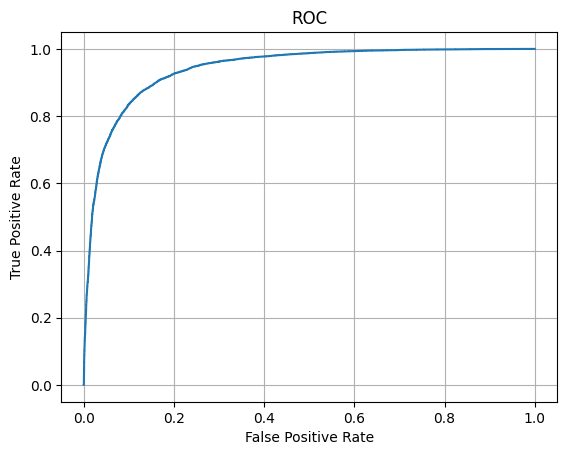

AUC ROC: 0.9420113727999999


In [ ]:
#построение ROC-кривой и AUC ROC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print('AUC ROC:', auc(fpr, tpr))

### 11) Сделали выводы по результатам применения рекуррентной нейронной сети для решения задачи определения тональности текста.  

Таблица1:

| Модель   | Количество настраиваемых параметров | Количество эпох обучения | Качество классификации тестовой выборки |
|----------|-------------------------------------|---------------------------|-----------------------------------------|
| Рекуррентная | 184 897                              | 5                        | accuracy:0.8659     ; loss:0.3349     ; AUC ROC:0.9420                                   |


#### По результатам применения рекуррентной нейронной сети, а также по данным таблицы 1 можно сделать вывод, что модель хорошо справилась с задачей определения тональности текста. Показатель accuracy = 0.8659 превышает требуемый порог 0.8. Значение AUC ROC = 0.9420 (> 0.9) говорит о высокой способности модели различать два класса (положительные и отрицательные отзывы). Модель показала хорошие результаты по метрикам precision и recall: для негативных отзывов precision = 0.91, recall = 0.82; для позитивных отзывов precision = 0.83, recall = 0.92.